Thermal Radiation Transport Reduced Order Modeling
Standard Shifted Operator Inference Method
Simon Butson

In [1]:
import numpy as np
import math
import pandas as pd
import scipy
import scipy.linalg as la
from scipy.integrate import solve_ivp
import scipy.sparse as sparse
import matplotlib.pyplot as plt
import h5py

import opinf

In [2]:
# Open the snapshot files to obtain radiation energy and time step data
U = []
t = np.zeros(141)

for i in range(141):
    filename = f'olson_hdf5_plt_cnt_{i:04d}'
    with h5py.File(filename, 'r') as f:
        if 'erad' in f:
            erad_data = f['erad'][...]
            if isinstance(erad_data, np.ndarray):
                erad_data = erad_data.squeeze()
                U.append(erad_data)
        if 'real scalars' in f:
              t[i] = f['real scalars'][0][1]      

Q = np.array(U)  # Convert the list to a NumPy array
Q = np.transpose(Q) # Transpose the array

print(Q.shape)

# Scale t from picoseconds
t = t*(10**12)

# Setup the x values
x = np.linspace(0,1,100)
dx = x[1]-x[0]

(100, 141)


(140,)
(100, 140)


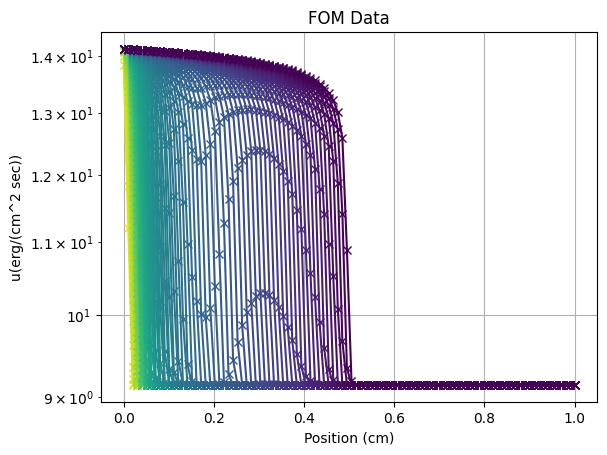

In [3]:
# Initial Conditions
# Remove flat initial conditions column from Q to help with training later on
Q = np.delete(Q, [0], 1)
t = np.delete(t, [0])

Q_old = Q.copy() # Save copy of initial data for comparison after solving

# Scale data logarithmically
Q = np.log10(Q)
print(t.shape)
print(Q.shape)

# Calculate intervals between times
dt = np.zeros(len(t)-1)
for i in range(len(t)-1):
    dt[i] = t[i+1]-t[i]

# Number of training snapshots
train_snaps = 100
# Plot training data

fig, ax = plt.subplots()
color = iter(plt.cm.viridis_r(np.linspace(.05, 1, train_snaps)))
for j in range(train_snaps):
    ax.plot(x, Q[:,j], color=next(color), marker='x', label=fr"$u_{{{j}}}$")

ax.set(xlabel='Position (cm)', ylabel='u(erg/(cm^2 sec))',
       title='FOM Data')
#ax.legend()
ax.grid()
plt.yscale("log")
plt.show()

51.0
[-3.62954078e-06  6.77907693e-04 -4.66044742e-02  2.14205109e+00
  4.28723387e+00]
[-9.30109631e-09  1.99029168e-06 -1.54099247e-04  5.13770598e-03
 -6.81245102e-02  1.43727539e+01]
15.713609


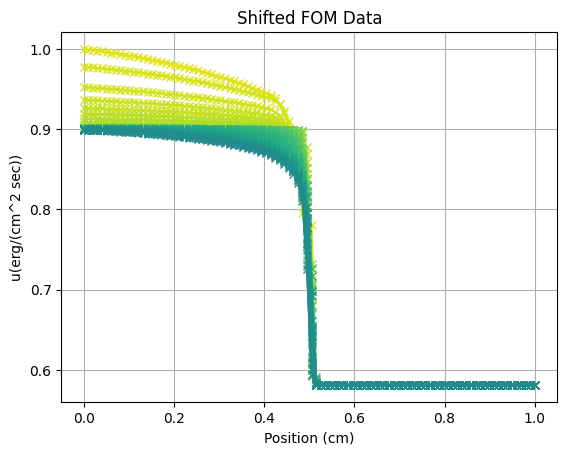

In [4]:
# Determine the points where the shock discontinuity reaches the minimum value to shift the snapshots about
shift_points = np.zeros(len(t)-1)

for ii in range(len(t)-1):
    for jj in range(100):
        if Q[jj,ii] < 9.3:
            shift_points[ii] = jj
            break

# Center point about which to shift
shift = shift_points[train_snaps]

print(shift)

#print(shift_points)

#print(Q.shape)

x_shift = np.zeros(len(t))
scale = np.zeros(len(t))

# Loop to shift the data and extrapolate values leftwards
for k in range(0,len(t)-1):
    u0 = Q[0,k]
    u1 = Q[1,k]
    u2 = Q[2,k]
    d = (u0-u1)/2
    #print(d)
    
    #extrap_poly = np.polyfit(x[int(x_shift[k]):int(x_shift[k]+2)], Q[int(x_shift[k]):int(x_shift[k]+2),k], 4)
    extrap_poly = np.polyfit(x[0:5], Q[0:5,k], 2)
    #print("for k =", k , x[0:5], Q[0:5,k])
    ep = np.poly1d(extrap_poly)
    #print(ep)
    x_shift[k] = shift-shift_points[k]
    Q[:,k] = np.roll(Q[:,k], int(x_shift[k]))
    #scale[k] = Q[int(shift-1),k]/Q[int(shift-1),train_snaps]
    #Q[0:int(x_shift[k]),k] = u0

    n = int(x_shift[k])
    count = 0
    
    while n >= 0:
        if k > 25:
            Q[n,k] = Q[n+1,k] + d/2.6
            if count < 3: 
                d /= 1.02 # need to fine-tune this value
            elif count < 6:
                d /= 1.10
            elif count < 9:
                d /= 1.20
            else:
                d /= 1.03
        else:
            Q[n,k] = Q[n+1,k] + d/2
            if count < 3: 
                d /= 1.02 # need to fine-tune this value
            elif count < 6:
                d /= 1.5
            elif count < 9:
                d /= 1.7
            else:
                d /= 1.03
       
        count+=1
        n -= 1

# Fit a polynomial to model the discontinuity position as a function of time
position = np.polyfit(t[:-1],shift_points,4)
print(position)
p = np.poly1d(position)

# Polynomial function to model the intial boundary condition
initial = np.polyfit(t[:-1],Q[0,:-1],5)
print(initial)
q0_p = np.poly1d(initial)

# Normalize the data after shifting
Qmax = np.max(Q)

print(Qmax)


Q = Q/Qmax 

fig1, ax1 = plt.subplots()
color = iter(plt.cm.viridis_r(np.linspace(.05, 1, train_snaps)))
for j in range(train_snaps):
    if j % 2 == 0:
        ax1.plot(x, Q[:,j], color=next(color), marker='x', label=fr"$u_{{{j}}}$")

ax1.set(xlabel='Position (cm)', ylabel='u(erg/(cm^2 sec))',
       title='Shifted FOM Data')
#ax1.legend()
ax1.grid()
plt.yscale("linear")
plt.show()

In [5]:
# Split the data into two regions 
# First region includes the downwards sloping parts before the shock discontinuity
# Second region includes the shock discontinuity and flat minumum

boundary_index = 49

Q1 = Q[:boundary_index,:]
Q2 = Q[boundary_index:,:]

x1 = x[:boundary_index]
x2 = x[boundary_index:]


In [6]:
 # Take scaled and shifted intial condition
q01 = Q1[:,0]
q02 = Q2[:,0]

# Estimate time derivatives (dq/dt) for each training snapshot.
#Qdot_train = (Q[:, 1:train_snaps] - Q[:, :train_snaps-1]) / dt[:train_snaps-1] # dx factor used to scale down Qdot to improve stability
Qdot_train1 = opinf.utils.ddt_nonuniform(states = Q1[:,1:train_snaps], t = t[:train_snaps-1])
Q_train1 = Q1[:, 1:train_snaps]              # Training snapshots.
#U_train = U[:,1:train_snaps]           # Training inputs. 

Qdot_train2 = opinf.utils.ddt_nonuniform(states = Q2[:,1:train_snaps], t = t[:train_snaps-1])
Q_train2 = Q2[:, 1:train_snaps]              # Training snapshots.


print(f"shape of Q_train1:\t{Q_train1.shape}")
print(f"shape of Qdot_train1:\t{Qdot_train1.shape}")

print(f"shape of Q_train2:\t{Q_train2.shape}")
print(f"shape of Qdot_train2:\t{Qdot_train2.shape}")
#print(f"shape of U_train:\t{U_train.shape}")

shape of Q_train1:	(49, 99)
shape of Qdot_train1:	(49, 99)
shape of Q_train2:	(51, 99)
shape of Qdot_train2:	(51, 99)


PODBasis
Full-order dimension    n = 49
Reduced-order dimension r = 7


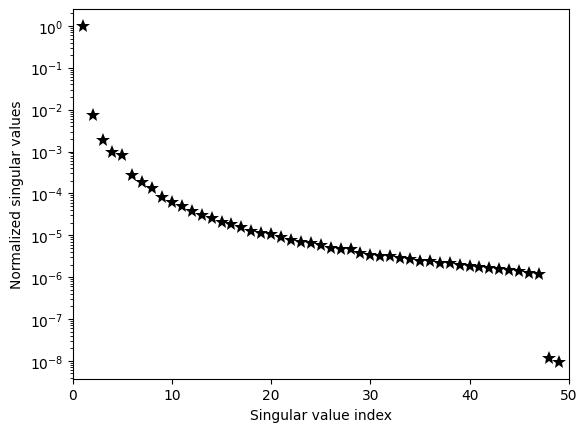

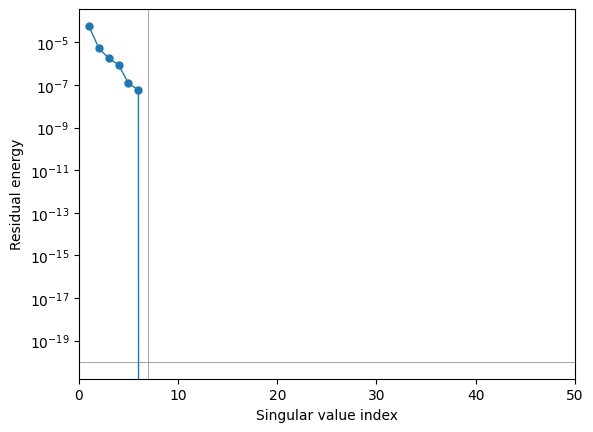

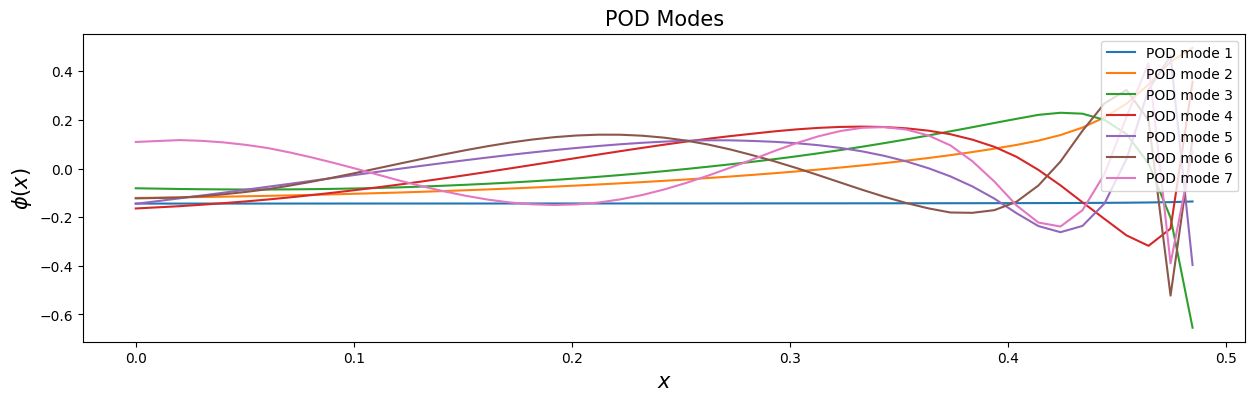

PODBasis
Full-order dimension    n = 51
Reduced-order dimension r = 4


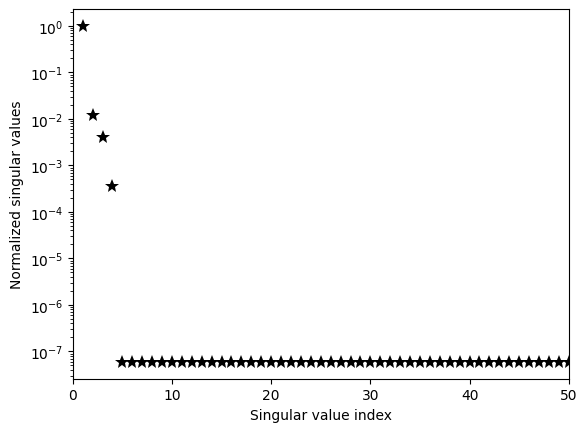

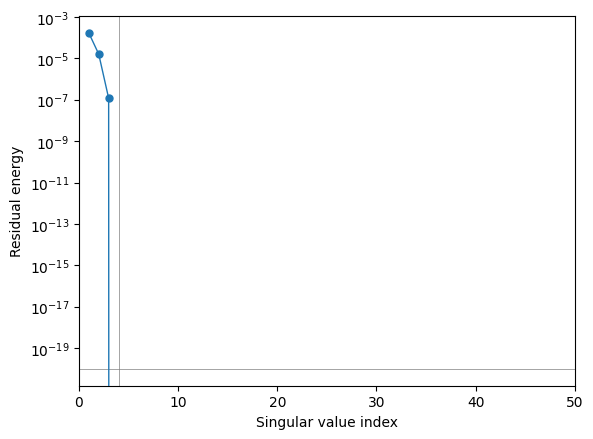

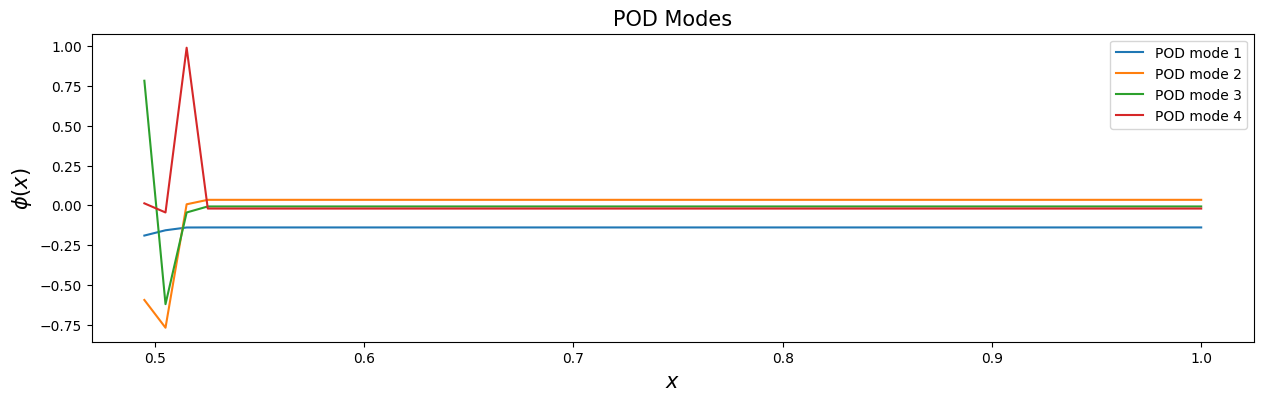

In [7]:
# Compute the POD basis for Region 1, using the residual energy decay to select r.
basis1 = opinf.basis.PODBasis().fit(Q_train1, residual_energy=1e-12)
print(basis1)

rank1 = basis1.shape[1]

# Check the decay of the singular values.
basis1.plot_svdval_decay()
plt.xlim(0, 50)

# Check the decay of the residual energy based on the singular values.
basis1.plot_residual_energy(threshold=1e-20)
plt.xlim(0, 50)
plt.show()

fig, ax = plt.subplots(figsize=(15, 4))
for ii in range(rank1):
    ax.plot(x1, basis1[:,ii],  label=f"POD mode {ii+1}")

ax.set_xlabel(r"$x$", fontsize=15)
ax.set_ylabel(r"$\phi(x)$", fontsize=15)
ax.set_title("POD Modes", fontsize=15)
plt.legend(loc="upper right")
plt.show()

# Compute the POD basis for Region 2, using the residual energy decay to select r.
basis2 = opinf.basis.PODBasis().fit(Q_train2, residual_energy=1e-12)
print(basis2)

rank2 = basis2.shape[1]

# Check the decay of the singular values.
basis2.plot_svdval_decay()
plt.xlim(0, 50)

# Check the decay of the residual energy based on the singular values.
basis2.plot_residual_energy(threshold=1e-20)
plt.xlim(0, 50)
plt.show()

fig, ax = plt.subplots(figsize=(15, 4))
for ii in range(rank2):
    ax.plot(x2, basis2[:,ii],  label=f"POD mode {ii+1}")

ax.set_xlabel(r"$x$", fontsize=15)
ax.set_ylabel(r"$\phi(x)$", fontsize=15)
ax.set_title("POD Modes", fontsize=15)
plt.legend(loc="upper right")
plt.show()

In [8]:
def regularizer(r, λ1, λ2):
    """Return the regularizer that penalizes all operator elements by λ1,
    except for the quadratic operator elements, which are penalized by λ2.
    Parameters
    ----------
    r : int
        Dimension of the ROM.
    λ1 : float
        Regularization hyperparameter for the non-quadratic operators.
    λ2 : float
        Regularization hyperparameter for the quadratic operator.

    Returns
    -------
    diag(𝚪) : (d,) ndarray
        Diagonal entries of the dxd regularizer 𝚪.
    """
    r1 = 1 + r
    r2 = r + r*(r + 1)//2
    diag𝚪 = np.full(r2, λ1)
    diag𝚪[r1:-1] = λ2
    print(diag𝚪)
    return diag𝚪

In [17]:
# Train the models for both regions.
rom1 = opinf.ContinuousOpInfROM(modelform="AH")
regm1 = regularizer(rank1, 11*10**(3), 11*10**(2))

reg1 = opinf.lstsq.TikhonovSolver(regm1) # Use with models of the form AH

rom1.fit(basis=basis1, states=Q_train1, ddts=Qdot_train1, solver=reg1)

rom2 = opinf.ContinuousOpInfROM(modelform="AH")
regm2 = regularizer(rank2, 7*10**(3), 7*10**(2))

reg2 = opinf.lstsq.TikhonovSolver(regm2) # Use with models of the form AH

rom2.fit(basis=basis2, states=Q_train2, ddts=Qdot_train2, solver=reg2)

# Looking at eigenvalues of A-matrix to quickly check stability
# Positive real parts suggest instability
#print(np.real(np.linalg.eigvals(rom.A_.entries)))

[11000 11000 11000 11000 11000 11000 11000 11000  1100  1100  1100  1100
  1100  1100  1100  1100  1100  1100  1100  1100  1100  1100  1100  1100
  1100  1100  1100  1100  1100  1100  1100  1100  1100  1100 11000]
[7000 7000 7000 7000 7000  700  700  700  700  700  700  700  700 7000]


Reduced-order model structure: dq / dt = Aq(t) + H[q(t) ⊗ q(t)]
Full-order dimension    n = 51
Reduced-order dimension r = 4

In [18]:
# Solve the ROMs for both Regions 

# Express the initial condition in the coordinates of the basis.
q0_1 = basis1.compress(q01)
q0_2 = basis2.compress(q02)
tmax = 80

# Generate a finer temporal mesh for use when solving the model
t1 = np.linspace(0,tmax,1000001)
dt1 = t1[1]-t1[0] 

print(t1)

# Can use the predict function to solve non-linear state-space models
Q_ROM1 = rom1.predict(q01,t1, decompress=True, method='BDF') 
Q_ROM2 = rom2.predict(q02,t1, decompress=True, method='BDF')

print(Q_ROM1.shape)
print(Q_ROM2.shape)

Q_ROM = np.vstack((Q_ROM1,Q_ROM2))

print(Q_ROM.shape)

# Undo normalization of ROM to obtain full values
Q_ROM = Q_ROM*Qmax
#Q_ROM = 10**Q_ROM # Bring ROM out of log10 scale

[0.000000e+00 8.000000e-05 1.600000e-04 ... 7.999984e+01 7.999992e+01
 8.000000e+01]
(49, 1000001)
(51, 1000001)
(100, 1000001)


1000001
0.003840942134962333
0.0022852163944566684
9.137221
9.137146
9.137137
9.137076
9.136794
9.136433
9.136071
9.13571


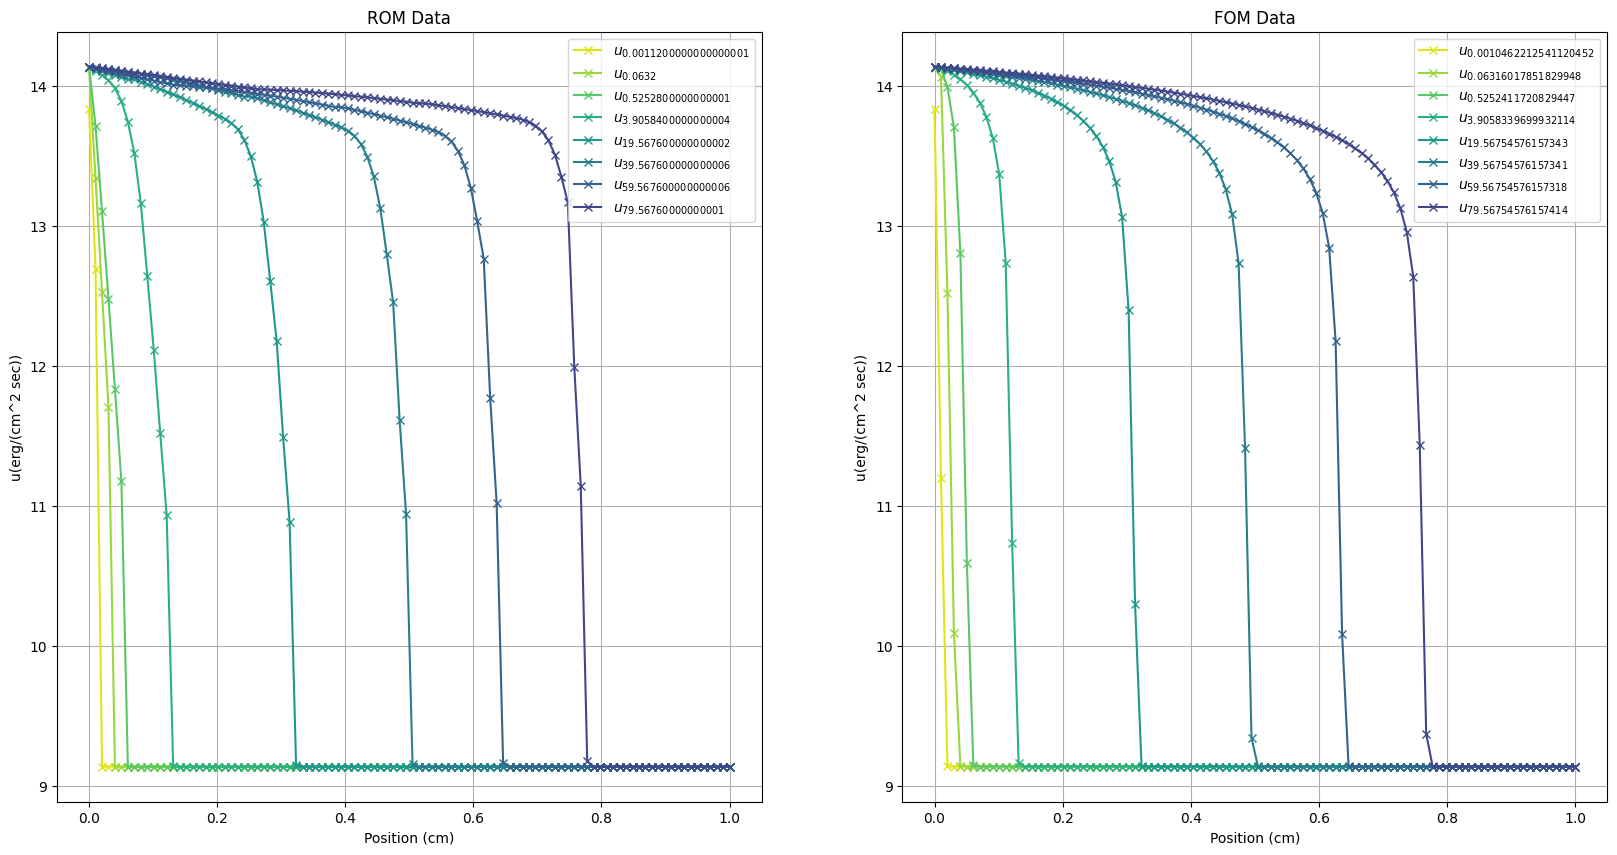

In [19]:
# Plot the solved model as a function of time 

t_solve = Q_ROM.shape[1]
print(t_solve)

# Shift Times
plot_values = np.linspace(0, len(t)-2, 8) # Equally spaced snapshot values to plot at
plot_times = t[plot_values.astype(int)] # Array of times corresponding to the snapshots to be plotted
plot_indices = np.zeros(8) 
t_shift = t[train_snaps] # Time corresponding to the center shift snapshot
count = 0
for index in range(len(plot_times)):
    while t1[count] < plot_times[index]:
        count+=1
    plot_indices[index] = count # Finds the index in the ROM time array corresponding to the snapshot times to be plotted

# Align the boundary vertically
gap = Q_ROM[boundary_index-1,:]-Q_ROM[boundary_index,:]
Q_ROM[:boundary_index,:] = Q_ROM[:boundary_index,:]-gap

x_shiftROM = np.zeros_like(plot_indices)
x_shiftROM2 = np.zeros_like(plot_indices)
for num1 in range(len(plot_indices)):
    x_shiftROM[num1] = round((shift-shift_points[int(plot_values[num1])])) # Exact shift method for times corresponding to snapshots  
    #x_shiftROM[num1] = round(shift-p(plot_times[num1])) # Polynomial position generalizable to any time 
    Q_ROM[:,int(plot_indices[num1])] = np.roll(Q_ROM[:,int(plot_indices[num1])], -1*int(x_shiftROM[num1]))
#Remove jump discontinuities and extrapolate values as needed
    for num2 in range(99):
        if plot_times[num1] < t_shift:
           if Q_ROM[num2+1,int(plot_indices[num1])] - Q_ROM[num2,int(plot_indices[num1])] > 2.5:
               Q_ROM[num2+1,int(plot_indices[num1])] = Q_ROM[num2,int(plot_indices[num1])]
        else:
            boundary_index = np.argmax(Q_ROM[:,int(plot_indices[num1])])
            slope = Q_ROM[boundary_index,int(plot_indices[num1])]-Q_ROM[boundary_index+1,int(plot_indices[num1])]
            print(slope)
            slope_correction = 3
            boundary_val = np.max(Q_ROM[:,int(plot_indices[num1])])
            counter = boundary_index-1
            while(counter >= 0):
                Q_ROM[int(counter),int(plot_indices[num1])] = Q_ROM[int(counter+1),int(plot_indices[num1])]+ slope*slope_correction
                counter-=1
            break
            
#print(x_shiftROM)

# Scale final results based on initial conditions
for ii in range(len(plot_indices)):
    scale_factor = (Q_ROM[0,int(plot_indices[ii])]-9.137)/(np.log10(Q_old[0,int(plot_values[ii])])-9.137)
    Q_ROM[:,int(plot_indices[ii])] = np.where((Q_ROM[:,int(plot_indices[ii])]-9.137) > 0,(Q_ROM[:,int(plot_indices[ii])]-9.137)/scale_factor,0) + 9.137


# Plot both the ROM & FOM in log10 space (9 to 14 instead of 10^9 to 10^14) for comparison
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20, 10))
color1 = iter(plt.cm.viridis_r(np.linspace(.05, 1, 10)))
color2 = iter(plt.cm.viridis_r(np.linspace(.05, 1, 10)))
for n in plot_indices:
        ax1.plot(x, Q_ROM[:,int(n)], color=next(color1), marker='x', label=fr"$u_{{{t1[int(n)]}}}$")

for m in plot_values:
        ax2.plot(x, np.log10(Q_old[:,int(m)]), color=next(color2), marker='x', label=fr"$u_{{{t[int(m)]}}}$")
        print(np.min(np.log10(Q_old[:,int(m)])))

ax1.set(xlabel='Position (cm)', ylabel='u(erg/(cm^2 sec))', title='ROM Data')
ax1.legend()
ax1.grid()
ax2.set(xlabel='Position (cm)', ylabel='u(erg/(cm^2 sec))', title='FOM Data')
ax2.legend()
ax2.grid()
ax1.set_yscale("linear")
ax2.set_yscale("linear")
plt.show()


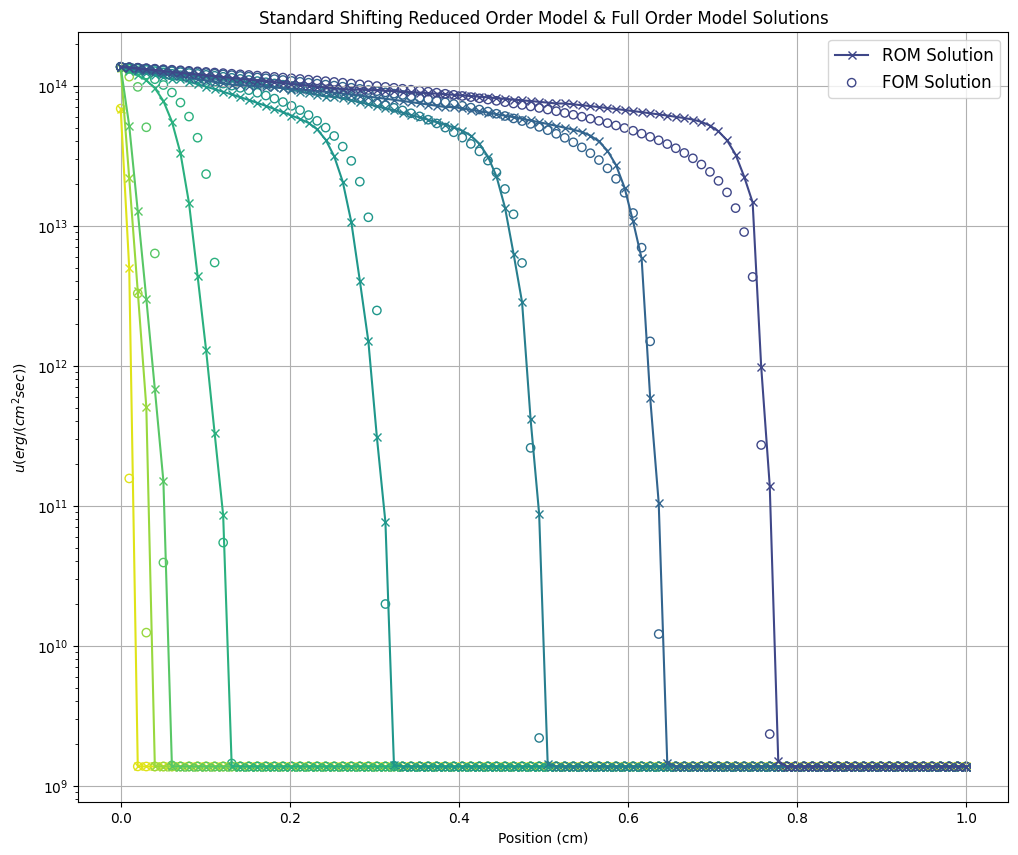

Mean absolute percentage error at time t = 0.0011200000000000001 is 30.662074483652 %
Mean absolute percentage error at time t = 0.0632 is 40.78487699479219 %
Mean absolute percentage error at time t = 0.5252800000000001 is 6.148946295112559 %
Mean absolute percentage error at time t = 3.9058400000000004 is 5.669779240082067 %
Mean absolute percentage error at time t = 19.567600000000002 is 9.43174437082917 %
Mean absolute percentage error at time t = 39.567600000000006 is 42.59569055386045 %
Mean absolute percentage error at time t = 59.567600000000006 is 15.114350246815091 %
Mean absolute percentage error at time t = 79.56760000000001 is 81.10847932838246 %
The max error is:  5852.089268655928 %


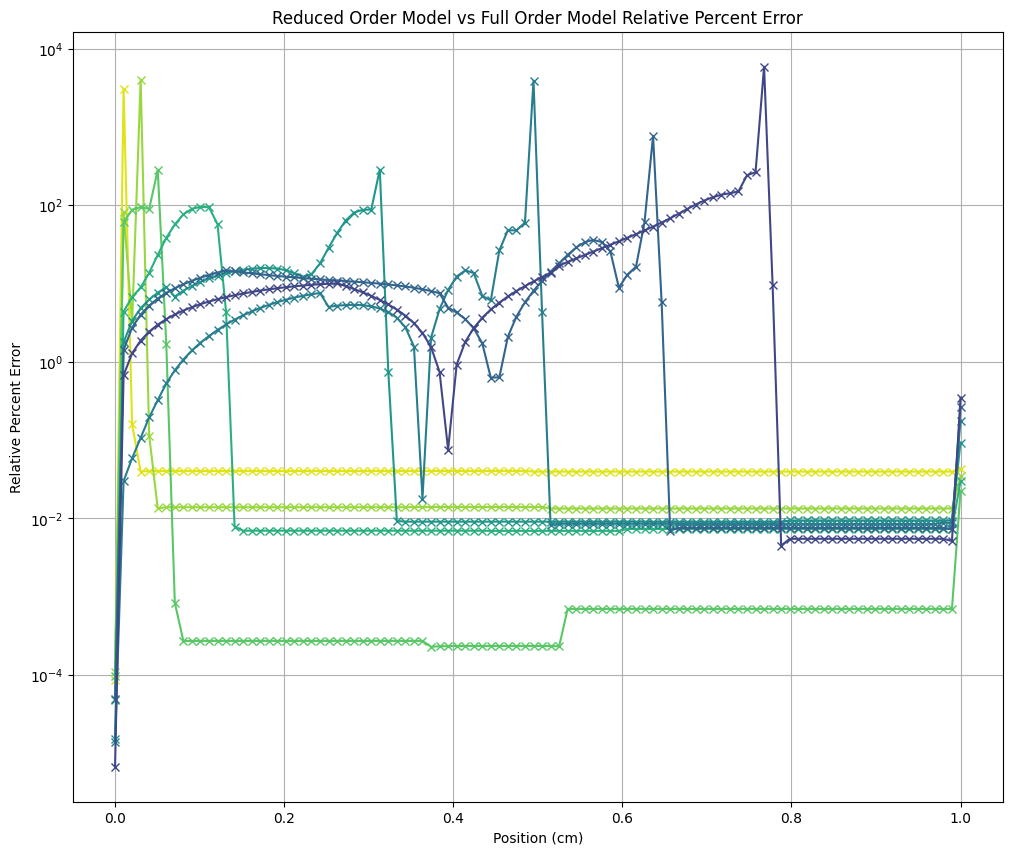

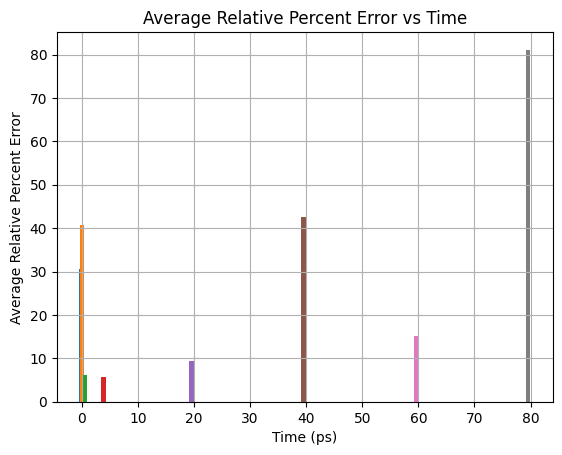

In [20]:
# Plot the ROM & FOM on the same plot for direct comparison
# FOM data plotted using x's and ROM data plotted as a continuous line
fig, ax = plt.subplots()
color1 = iter(plt.cm.viridis_r(np.linspace(.05, 1, 10)))
color2 = iter(plt.cm.viridis_r(np.linspace(.05, 1, 10)))
for n in plot_indices:
        #ax.plot(x, 10**Q_ROM[:,int(n)], color=next(color1), marker='x', label=fr"$u_{{{t1[int(n)]}}}$")
        if n == plot_indices[7]:
            ax.plot(x, 10**Q_ROM[:,int(n)], color=next(color1), marker='x', label = "ROM Solution")
        else:
            ax.plot(x, 10**Q_ROM[:,int(n)], color=next(color1), marker='x')

for m in plot_values:
    if m == plot_values[7]:
        ax.scatter(x, Q_old[:,int(m)], color=next(color2), marker='o',facecolor='none', label="FOM Solution")
    else:
        ax.scatter(x, Q_old[:,int(m)], color=next(color2), marker='o',facecolor='none')

ax.set(xlabel=fr"Position (cm)", ylabel=fr"$u(erg/(cm^2 sec))$",
       title='Standard Shifting Reduced Order Model & Full Order Model Solutions')
ax.legend(fontsize=12)
ax.grid()
ax.set_yscale("log")
fig.set_size_inches(12,10)
plt.show()

# Calculate & Plot Error
fig2, ax2 = plt.subplots()
color3 = iter(plt.cm.viridis_r(np.linspace(.05, 1, 10)))

error = np.zeros((100,len(plot_indices)))
mean_error = np.zeros(8)

for i in range(len(plot_indices)):
    #error[:,i] = 100*(10**Q_ROM[:,int(plot_indices[i])] - Q_old[:,int(plot_values[i])])/(10**Q_ROM[:,int(plot_indices[i])]) # Error in %
    error[:,i] = 100*np.abs((Q_old[:,int(plot_values[i])] - 10**Q_ROM[:,int(plot_indices[i])])/Q_old[:,int(plot_values[i])]) # Error in %
    #ax2.plot(x, error[:,i], color=next(color3), label=fr"$u_{{{t1[int(plot_indices[i])]}}}$")
    ax2.plot(x, error[:,i], color=next(color3), marker='x')
    print("Mean absolute percentage error at time t =", t1[int(plot_indices[i])], "is", np.mean(np.abs(error[:,i])), "%")
    mean_error[i] = np.mean(np.abs(error[:,i]))

print("The max error is: ", np.max(np.abs(error)),"%")

ax2.set(xlabel='Position (cm)', ylabel='Relative Percent Error', title='Reduced Order Model vs Full Order Model Relative Percent Error')
#ax2.legend()
ax2.grid()
ax2.set_yscale("log")
fig2.set_size_inches(12,10)
plt.show()

fig3, ax3 = plt.subplots()
color4 = iter(plt.cm.viridis_r(np.linspace(.05, 1, 10)))
for k in range(len(plot_indices)):
    ax3.bar(t1[int(plot_indices[k])],mean_error[k])
ax3.set(xlabel='Time (ps)', ylabel='Average Relative Percent Error', title='Average Relative Percent Error vs Time')
ax3.grid()
plt.show()

### 